In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fast')

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from scipy.special import comb

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import statsmodels.api as sm
import os

In [2]:
df = pd.read_csv('data/3-accidents-dummies-next.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Distance(mi)', 'Side', 'City', 'County', 'State', 'Zipcode',
       'Weather_Timestamp', 'Temperature', 'Humidity_pct', 'Visibility_mi',
       'Windspeed_mph', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [4]:
df = df[['Severity', 'Start_Time', 'End_Time',
       'Distance(mi)', 'Side', 'City', 'State',
       'Weather_Timestamp', 'Temperature', 'Humidity_pct', 'Visibility_mi',
       'Windspeed_mph', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']]

## California

In [5]:
df = df[df['State'] == 'CA']

In [6]:
df.shape

(645967, 29)

## San Francisco

In [7]:
df = df[df['City'] == 'San Francisco']

In [8]:
df.shape

(8307, 29)

In [9]:
df.drop(columns=['City', 'State'], inplace=True)

In [10]:
df.Side.value_counts()

R    7865
L     442
Name: Side, dtype: int64

In [11]:
df['Side'] = df['Side'].map({'L':1, 'R':0})

In [12]:
df.drop(columns=['Start_Time', 'End_Time'], inplace=True)

In [13]:
df.shape

(8307, 25)

In [14]:
df['day_of_week'] = pd.to_datetime(df['Weather_Timestamp'])

In [15]:
df['day_of_week'] = df['day_of_week'].dt.dayofweek

In [16]:
df.day_of_week.value_counts()

2    1568
3    1444
4    1328
1    1299
0    1172
6     749
5     747
Name: day_of_week, dtype: int64

In [17]:
df.drop('Weather_Timestamp',1,inplace=True)

In [18]:
df.shape

(8307, 25)

In [19]:
df = pd.concat([df, pd.get_dummies(df['Weather_Condition'])], axis=1)

In [20]:
df.drop('Weather_Condition',1,inplace=True)

In [21]:
df.shape

(8307, 48)

In [22]:
df

,Severity,Distance(mi),Side,Temperature,Humidity_pct,Visibility_mi,Windspeed_mph,Amenity,Bump,Crossing,...,Mostly Cloudy / Windy,Overcast,Partly Cloudy,Partly Cloudy / Windy,Patches of Fog,Rain,Rain / Windy,Scattered Clouds,Shallow Fog,Smoke
733,3,0.000,0,71.1,55.0,10.0,4.6,0,0,0,...,0,0,1,0,0,0,0,0,0,0
763,3,0.000,0,73.0,44.0,10.0,19.6,0,0,0,...,0,0,1,0,0,0,0,0,0,0
764,2,0.000,0,77.0,40.0,10.0,11.5,0,0,0,...,0,0,1,0,0,0,0,0,0,0
786,3,0.000,0,71.1,47.0,10.0,24.2,0,0,0,...,0,0,1,0,0,0,0,0,0,0
806,2,0.000,0,61.0,67.0,10.0,20.7,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897551,2,0.305,0,71.0,73.0,10.0,7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2897559,2,0.674,0,78.0,56.0,10.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2897561,2,0.362,0,78.0,56.0,10.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2897574,2,0.037,0,73.0,61.0,10.0,17.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [23]:
y = df.pop('Severity')

In [24]:
X = df

---
# <center><code>Linear Regression</code></center>
---

In [29]:
X1 = X
y1 = y

In [30]:
X1 = sm.add_constant(X1)
lr_model = sm.OLS(y1, X1)
lr_result = lr_model.fit()
lr_result.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Severity   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     18.83
Date:                Thu, 06 Feb 2020   Prob (F-statistic):          7.52e-135
Time:                        16:25:38   Log-Likelihood:                -5696.5
No. Observations:                8307   AIC:                         1.148e+04
Df Residuals:                    8263   BIC:                         1.179e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.0764      0.088     23.568      0.000       1.904       2.249
Distance(mi)                     0.0003      0.014      0.021      0.983      -0.028       0.029
Side                            -0.1139      0.025     -4.538      0.000      -0.163      -0.065
Temperature                      0.0019      0.001      2.089      0.037       0.000       0.004
Humidity_pct                     0.0021      0.000      4.659      0.000       0.001       0.003
Visibility_mi                    0.0085      0.005      1.593      0.111      -0.002       0.019
Windspeed_mph                   -0.0025      0.001     -2.673      0.008      -0.004      -0.001
Amenity                         -0.1918      0.033     -5.731      0.000      -0.257      -0.126
Bump                         -1.661e-15   5.26e-16     -3.161      0.002   -2.69e-15   -6.31e-16
Crossing                        -0.1681      0.029     -5.817      0.000      -0.225      -0.111
Give_Way                         0.5042      0.185      2.728      0.006       0.142       0.867
Junction                        -0.1074      0.013     -8.107      0.000      -0.133      -0.081
No_Exit                       1.903e-15   5.51e-16      3.454      0.001    8.23e-16    2.98e-15
Railway                          0.1726      0.037      4.605      0.000       0.099       0.246
Roundabout                    1.111e-15   5.55e-16      2.002      0.045    2.34e-17     2.2e-15
Station                         -0.1538      0.029     -5.224      0.000      -0.212      -0.096
Stop                            -0.2499      0.065     -3.843      0.000      -0.377      -0.122
Traffic_Calming                  0.2164      0.217      0.996      0.319      -0.209       0.642
Traffic_Signal                  -0.0946      0.026     -3.624      0.000      -0.146      -0.043
Sunrise_Sunset                   0.0397      0.028      1.409      0.159      -0.016       0.095
Civil_Twilight                  -0.0567      0.037     -1.549      0.121      -0.129       0.015
Nautical_Twilight               -0.0362      0.037     -0.992      0.321      -0.108       0.035
Astronomical_Twilight           -0.0333      0.029     -1.148      0.251      -0.090       0.024
day_of_week                      0.0146      0.003      4.947      0.000       0.009       0.020
Clear                            0.1692      0.039      4.363      0.000       0.093       0.245
Cloudy                          -0.0329      0.043     -0.759      0.448      -0.118       0.052
Cloudy / Windy                  -0.0569      0.133     -0.429      0.668      -0.317       0.203
Fair                            -0.0593      0.038     -1.549      0.121      -0.134       0.016
Fair / Windy                    -0.0901      0.060     -1.507      0.132    

In [31]:
lr_result.params

const                           2.076370e+00
Distance(mi)                    3.067656e-04
Side                           -1.139443e-01
Temperature                     1.866965e-03
Humidity_pct                    2.137939e-03
Visibility_mi                   8.478504e-03
Windspeed_mph                  -2.546218e-03
Amenity                        -1.918484e-01
Bump                           -1.661162e-15
Crossing                       -1.680834e-01
Give_Way                        5.042413e-01
Junction                       -1.073603e-01
No_Exit                         1.902859e-15
Railway                         1.726175e-01
Roundabout                      1.111173e-15
Station                        -1.537999e-01
Stop                           -2.499282e-01
Traffic_Calming                 2.164165e-01
Traffic_Signal                 -9.464381e-02
Sunrise_Sunset                  3.972468e-02
Civil_Twilight                 -5.674476e-02
Nautical_Twilight              -3.624152e-02
Astronomic

In [32]:
lr_result.fittedvalues[0:5]

733    2.452882
763    2.394719
764    2.414259
786    2.385873
806    2.418687
dtype: float64

## p-value: 2.270459470776888e-10 | <code>heteroscedastic</code>

In [33]:
f_statistic, p_value, _ = sm.stats.diagnostic.het_goldfeldquandt(y1, X1, idx=1, alternative='two-sided')
print(p_value)

2.270459470776888e-10


---
# <center><code>Random Forest Regression</code></center>
---

## Preprocessing

In [34]:
X = np.asarray(df)

In [35]:
y = np.asarray(y)

In [36]:
X = preprocessing.StandardScaler().fit(X).transform(X)

## Train-Test-Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [39]:
rf = RandomForestRegressor()
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [41]:
parameters = [{'n_estimators': [10,30,100],
              'max_depth': [10,15,32]}]

In [42]:
grid = GridSearchCV(rf, parameters)
grid

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [10, 15, 32]

In [50]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [10, 15, 32]

In [51]:
BestRF = grid.best_estimator_
BestRF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## Grid Search R^2: <code>0.17808764155637336</code>

In [52]:
BestRF.score(X_test, y_test)

0.17808764155637336

In [53]:
testrf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [54]:
testrf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [55]:
yhat = testrf.predict(X_test)

## Random Forest R^2: <code>0.17889971042330746</code>

In [56]:
testrf.score(X_test, y_test)

0.17889971042330746

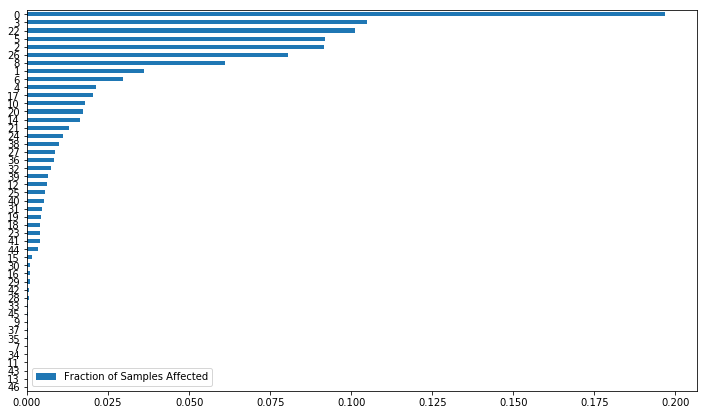

In [61]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : testrf.feature_importances_})
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(12,7))

array([3, 3, 2, ..., 2, 2, 2])

---

# <center><code>Gradient Boosted Regression</code></center>

---

In [ ]:
os.system("say 'you may continue working'")